# Bank loan model : The big picture


This case is about a bank (**Thera Bank**) which has a growing customer base.


Majority of these customers are **liability customers** (depositors) with varying size of deposits. The number of customers who are also borrowers (asset customers) is quite small, and **the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans**. 


In particular, the management wants to **explore ways of converting its liability customers to personal loan customers (while retaining them as depositors)**. 


A campaign that the bank ran last year for liability customers showed **a healthy conversion rate of over 9% success**. 


This has encouraged the retail marketing department to devise campaigns to better target marketing to increase the success ratio with a minimal budget.




## Framing the problem


### What is the business objective ?


The department wants to build a model that will **help them identify the potential customers who have a higher probability of purchasing the loan**. 

**This will increase the success ratio while at the same time reduce the cost of the campaign**.



### What is the type of learning ?



With the gathered information, we are ready to design our system.<br>

- This is a **supervised learning task** because the model can train on labeled examples (customers who actually purchased a loan). <br>


- It’s a **classification task** since the goal is to predict the likelihood of customers to purchase a loan or not. <br>



## Selecting a performance measure


The next step is to choose a performance measure. <br>

For our case, the main metric to use is the **recall** :   $$recall  = \frac{TP}{TP + FN}$$<br>
with **TP** : True Positives and **FN** : False Negatives



In machine learning, recall is a performance metric that measures the ability of a classification model to correctly identify all relevant instances of the positive class. <br>

It is particularly important in situations **where missing positive cases (false negatives) is more critical than incorrectly classifying negatives as positives**. <br>

In other words, we are interested in **detecting most of the customers that would purchase a loan** and **we accept a higher number of False Positive** detection.




Additionally, we will calculate : <br>
- the precision :  $$precision  = \frac{TP}{TP + FP}$$ <br>

- the F1 score :    $$F_1  = \frac{2}{\frac{1}{precision}+ \frac{1}{recall}} = 2 \times \frac{precision \times recall}{precision + recall} = \frac{TP}{TP +  \frac{FN + FP}{2}} $$ <br><br>


with **TP** : True Positives and **FN** : False Negatives


In machine learning, **precision** is a metric used to evaluate the performance of a classification model, especially in cases where the classes are imbalanced or when the cost of false positives is high.<br>
Precision focuses on the proportion of correctly identified positive instances out of all instances that were predicted as positive.

The **F1 score** is a performance metric used in machine learning to evaluate the accuracy of a classification model, especially when dealing with imbalanced datasets. <br>
It is the harmonic mean of precision and recall, providing a single score that balances the trade-off between them.


# Getting the data


## Import libraries


Here will be imported all the necessary libraries that we'll use for this task !

In [1]:
import warnings
warnings.filterwarnings(action = 'ignore')

# General libraries
import pandas as pd
import numpy as np
import math
from scipy.stats import iqr


# Visualization
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import plotly.express as px

# Split train set and test set
from sklearn.model_selection import train_test_split

# Geolocation libraries
import pgeocode 
from geopy.geocoders import Nominatim

# Preprocessing the data
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler

# Pipelines
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer


# Models
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier


# Scores
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import classification_report

# Saving/loading models
import joblib

## Import the data


We import the data and store it locally.

In [2]:
# Retrieve the data stored locally
path = "../data/raw_data"
banking_data = pd.read_excel(path + "/Bank_Personal_Loan_Modelling.xlsx", sheet_name="Data")

banking_data.head()

ID  Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
0   1   25           1      49     91107       4    1.6          1         0   
1   2   45          19      34     90089       3    1.5          1         0   
2   3   39          15      11     94720       1    1.0          1         0   
3   4   35           9     100     94112       1    2.7          2         0   
4   5   35           8      45     91330       4    1.0          2         0   

   Personal Loan  Securities Account  CD Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0  
2              0                   0           0       0           0  
3              0                   0           0       0           0  
4              0                   0           0       0           1

In [3]:
print(f"The data shape is : {banking_data.shape}")

The data shape is : (5000, 14)


## Describe the features


We have the following features : <br>
**ID**: Customer ID<br>
**Age**: Customer's age in completed years<br>
**Experience**: #years of professional experience<br>
**Income**: Annual income of the customer (**in thousands of dollars**) <br>
**ZIP_Code**: Home Address ZIP code.<br>
**Family**: Family size of the customer <br>
**CCAvg**: Avg. spending on credit cards per month (**in thousands of dollars**)<br>
**Education**: Education Level. 1: Undergrad; 2: Graduate; 3: Advanced/Professional<br>
**Mortgage**: Value of house mortgage if any (**in thousands of dollars**).<br>
**Personal Loan**: Did this customer accept the personal loan offered in the last campaign?<br>
**Securities Account**: Does the customer have a securities account with the bank?<br>
**CD Account**: Does the customer have a certificate of deposit (CD) account with the bank?<br>
**Online**: Does the customer use internet banking facilities?<br>
**CreditCard**: Does the customer use a credit card issued by UniversalBank?<br>



## Rewrite feature names


Updating the feature names for easier use.


In [4]:
# Updating the feature names for easier use.
banking_data = banking_data.rename(columns={
                                            "ZIP Code":"ZIP_Code", 
                                            "Personal Loan":"Personal_Loan",
                                            "Securities Account":"Securities_Account",
                                            "CD Account": "CD_Account"
                                            })

banking_data.head(2)

ID  Age  Experience  Income  ZIP_Code  Family  CCAvg  Education  Mortgage  \
0   1   25           1      49     91107       4    1.6          1         0   
1   2   45          19      34     90089       3    1.5          1         0   

   Personal_Loan  Securities_Account  CD_Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0

## Dropping features


We won't need the **ID column**. Let's drop it !



In [5]:
# We won't need the ID column. Let's drop it !
banking_data = banking_data.drop(columns=['ID'])
banking_data.head(2)

Age  Experience  Income  ZIP_Code  Family  CCAvg  Education  Mortgage  \
0   25           1      49     91107       4    1.6          1         0   
1   45          19      34     90089       3    1.5          1         0   

   Personal_Loan  Securities_Account  CD_Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0

## Cleaning the data

### Processing duplicates

We check the number of duplicated rows.

In [6]:
# Check number of rows before removing duplicates
print(f"Number of rows : {len(banking_data)}")

# Compute the number of duplicated rows
print(f"Number of duplicated rows : {banking_data.duplicated().sum()}")

# Remove duplicates
banking_data = banking_data.drop_duplicates() 

# Check number of rows before removing duplicates
print(f"Number of rows (AFTER dropping duplicates) : {len(banking_data)}")

Number of rows : 5000
Number of duplicated rows : 0
Number of rows (AFTER dropping duplicates) : 5000


There are no duplicated rows .


### Processing missing data




We check the percentage of missing values in the data at hand.

In [7]:
def get_missing_data(data):       
    # Counting the percentage of NaN for each column
    missing_data = data.isnull().sum().sort_values(ascending=False)/len(data)*100 #NaN percentage for each column

    # missing_data
    missing_data = missing_data[missing_data > 0]

    #Missing data column names
    missing_cols = missing_data.index.values.tolist()

    #Show missing data in percent
    return missing_data

missing_data = get_missing_data(banking_data)
missing_data

Series([], dtype: float64)

We don't have any missing values.


## Create longitude and latitude


It would be interesting to locate **geographically** each customer.<br>

Let's extract the coordinates (longitude and latitude) of each customer, through their ZIP code.


In [8]:
# Retrieve geographical info from zip code
ZIP_Codes = banking_data['ZIP_Code'].values.astype('str').tolist()
nomi = pgeocode.Nominatim('us')
df_PostalCode = nomi.query_postal_code(ZIP_Codes)
df_PostalCode['postal_code'] = df_PostalCode['postal_code'].values.astype('int64')

# Check
print(df_PostalCode.shape)
df_PostalCode.head()


(5000, 12)


postal_code country_code     place_name  state_name state_code  \
0        91107           US       Pasadena  California         CA   
1        90089           US    Los Angeles  California         CA   
2        94720           US       Berkeley  California         CA   
3        94112           US  San Francisco  California         CA   
4        91330           US     Northridge  California         CA   

                        county_name  county_code community_name  \
0                       Los Angeles         37.0            NaN   
1                       Los Angeles         37.0            NaN   
2                           Alameda          1.0            NaN   
3  City and County of San Francisco         75.0            NaN   
4                       Los Angeles         37.0            NaN   

   community_code  latitude  longitude  accuracy  
0             NaN   34.1510  -118.0889       4.0  
1             NaN   33.7866  -118.2987       4.0  
2             NaN   37.8738  -122.2549       4.0  
3             NaN   37.7195  -122.4411       4.0  
4             NaN   34.2283  -118.5368       4.0

We could extract the customers coordinates thanks to their Zip code.


Now, let's check for duplicated rows of coordinates dataframe.


In [9]:
# Check number of rows before removing duplicates
print(f"Number of rows : {len(df_PostalCode)}")

# Compute the number of duplicated rows
print(f"Number of duplicated rows : {df_PostalCode.duplicated().sum()}")

# Remove duplicates
df_PostalCode = df_PostalCode.drop_duplicates() 

# Check number of rows before removing duplicates
print(f"Number of rows (AFTER dropping duplicates) : {len(df_PostalCode)}")

Number of rows : 5000
Number of duplicated rows : 4533
Number of rows (AFTER dropping duplicates) : 467


Now, let's add the coordinates of each customer to our banking data.



In [10]:
# Create latitude and longitude columns
banking_data = pd.merge(banking_data,df_PostalCode[['postal_code', 'latitude', 'longitude']],
                        how='left',
                        left_on='ZIP_Code',
                        right_on='postal_code')

# Dropping postal_code (not needed anymore)
banking_data = banking_data.drop(columns='postal_code')

# Check
print(banking_data.shape)
banking_data.head(5)

(5000, 15)


Age  Experience  Income  ZIP_Code  Family  CCAvg  Education  Mortgage  \
0   25           1      49     91107       4    1.6          1         0   
1   45          19      34     90089       3    1.5          1         0   
2   39          15      11     94720       1    1.0          1         0   
3   35           9     100     94112       1    2.7          2         0   
4   35           8      45     91330       4    1.0          2         0   

   Personal_Loan  Securities_Account  CD_Account  Online  CreditCard  \
0              0                   1           0       0           0   
1              0                   1           0       0           0   
2              0                   0           0       0           0   
3              0                   0           0       0           0   
4              0                   0           0       0           1   

   latitude  longitude  
0   34.1510  -118.0889  
1   33.7866  -118.2987  
2   37.8738  -122.2549  
3   37.7195  -122.4411  
4   34.2283  -118.5368

**Let's check for missing data after creating longitude and latitude features!** 


In [11]:
missing_data = get_missing_data(banking_data)
missing_data

latitude     0.82
longitude    0.82
dtype: float64

**Less than 1%** of data is missing for latitude and longitude. We drop the rows with missing data.


In [12]:
# Less than 1% of data is missing for latitude and longitude. We drop the rows with missing data.
print(f"Number of rows  (BEFORE DROPPING) : {banking_data.shape}")
banking_data = banking_data.dropna()
print(f"Number of rows  (AFTER DROPPING) : {banking_data.shape}")


Number of rows  (BEFORE DROPPING) : (5000, 15)
Number of rows  (AFTER DROPPING) : (4959, 15)


**Let's check for missing data again.** 


In [13]:
# Let's check for missing data again.
get_missing_data(banking_data.dropna())

Series([], dtype: float64)

We don't have missing values anymore.



**Let's drop the ZIP_Code column.** 


In [14]:
# # Let's drop the ZIP_Code column.
# banking_data = banking_data.drop(columns="ZIP_Code")

# Exploring the data


## Quick exploration

In [15]:
# summary of the DataFrame
banking_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4959 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 4959 non-null   int64  
 1   Experience          4959 non-null   int64  
 2   Income              4959 non-null   int64  
 3   ZIP_Code            4959 non-null   int64  
 4   Family              4959 non-null   int64  
 5   CCAvg               4959 non-null   float64
 6   Education           4959 non-null   int64  
 7   Mortgage            4959 non-null   int64  
 8   Personal_Loan       4959 non-null   int64  
 9   Securities_Account  4959 non-null   int64  
 10  CD_Account          4959 non-null   int64  
 11  Online              4959 non-null   int64  
 12  CreditCard          4959 non-null   int64  
 13  latitude            4959 non-null   float64
 14  longitude           4959 non-null   float64
dtypes: float64(3), int64(12)
memory usage: 619.9 KB


In [16]:
# Descriptive statistics
banking_data.describe()

Age   Experience       Income      ZIP_Code       Family  \
count  4959.000000  4959.000000  4959.000000   4959.000000  4959.000000   
mean     45.345029    20.111313    73.820932  93168.258722     2.396854   
std      11.463912    11.469240    46.061924   1762.133154     1.147721   
min      23.000000    -3.000000     8.000000  90005.000000     1.000000   
25%      35.000000    10.000000    39.000000  91910.000000     1.000000   
50%      45.000000    20.000000    64.000000  93555.000000     2.000000   
75%      55.000000    30.000000    98.000000  94608.000000     3.000000   
max      67.000000    43.000000   224.000000  96150.000000     4.000000   

             CCAvg    Education     Mortgage  Personal_Loan  \
count  4959.000000  4959.000000  4959.000000    4959.000000   
mean      1.937286     1.880218    56.674128       0.095987   
std       1.744765     0.840058   101.888783       0.294603   
min       0.000000     1.000000     0.000000       0.000000   
25%       0.700000     1.000000     0.000000       0.000000   
50%       1.500000     2.000000     0.000000       0.000000   
75%       2.500000     3.000000   101.000000       0.000000   
max      10.000000     3.000000   635.000000       1.000000   

       Securities_Account   CD_Account       Online   CreditCard     latitude  \
count         4959.000000  4959.000000  4959.000000  4959.000000  4959.000000   
mean             0.104053     0.060899     0.597096     0.293809    35.786663   
std              0.305360     0.239170     0.490531     0.455552     2.105600   
min              0.000000     0.000000     0.000000     0.000000    32.562600   
25%              0.000000     0.000000     0.000000     0.000000    33.953300   
50%              0.000000     0.000000     1.000000     0.000000    35.385500   
75%              0.000000     0.000000     1.000000     1.000000    37.750900   
max              1.000000     1.000000     1.000000     1.000000    41.724300   

         longitude  
count  4959.000000  
mean   -120.038983  
std       2.090673  
min    -124.159300  
25%    -122.138800  
50%    -119.861200  
75%    -118.085700  
max    -115.573000

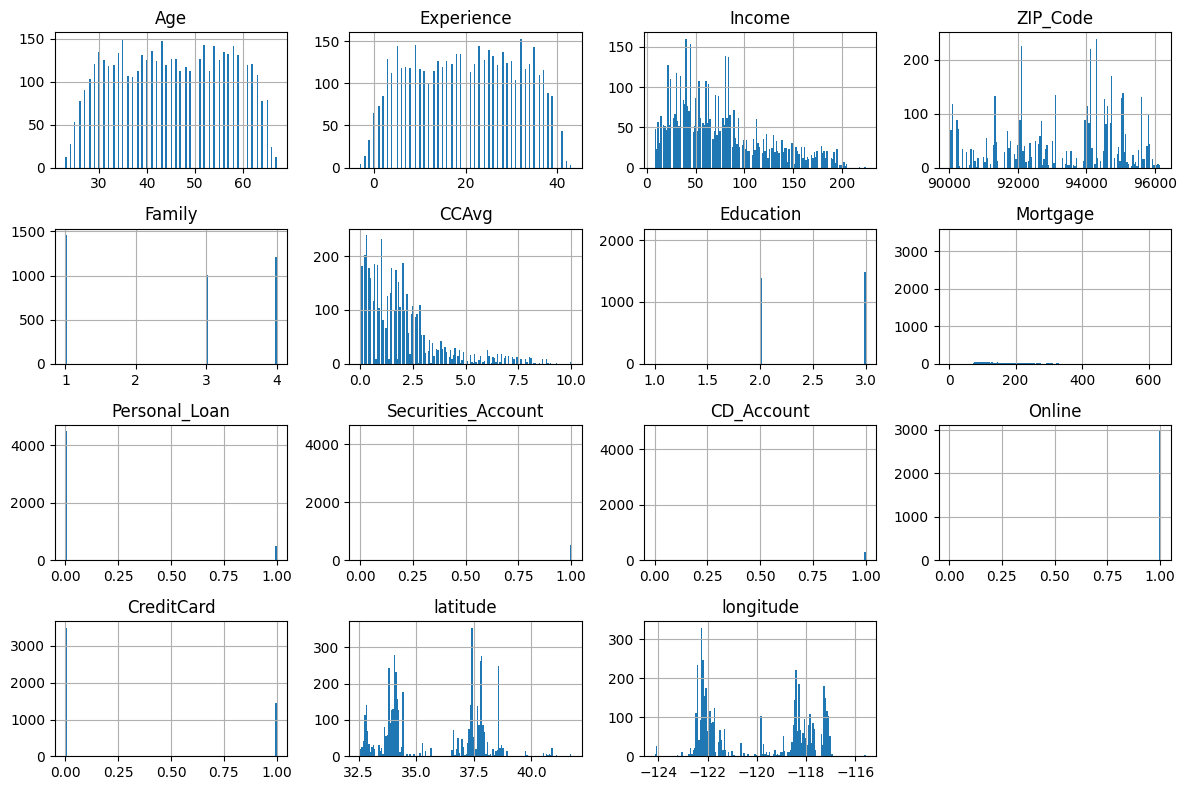

In [17]:
# Histogram of the DataFrame’s columns
banking_data.hist(bins=150, figsize=(12, 8))
plt.tight_layout()
plt.show()

## Test set and train set

### Check target balance


Our target is **Personal_Loan**. <br> 
Let's check the balance of the target.


In [18]:
# Our target is Personal_Loan. Let's check the balance of the target.
banking_data.Personal_Loan.value_counts()/len(banking_data)*100

0    90.401291
1     9.598709
Name: Personal_Loan, dtype: float64

**The data is very imbalanced !!**


Imbalanced dataset is a dataset where the classes are not balanced or equal.<br>
This means there are an unequal number of samples from each target class and some classes may have significantly more samples than others.


### Problems with Imbalanced Datasets


Imbalanced datasets can lead to algorithms that are biased towards the majority class. <br>


This means that any classification algorithm trained on an imbalanced dataset will often inaccurately classify minority classes as the majority class.


The performance of a machine learning model can become highly skewed when it is fed with imbalanced data.<br>

For example, our dataset has 90% class 0 and 10% class 1, then the learning model could be easily optimized to just predict all test input as belonging to class 0 and still get 90% accuracy!


If a model is trained on data which is heavily imbalanced, it can develop an incorrect understanding of the underlying trends in the data. The model may not be able to recognize how certain values are distributed among different classes or even how certain classes overlap with each other.

### Techniques to Handle Imbalanced Dataset



#### The approach to train test split


The approach to train test split when dealing with imbalanced datasets is to use **stratification**.<br>


Stratification is an important step in splitting imbalanced datasets into training and test sets.<br>

Stratification ensures that the proportion of each class remains the same across both the training and test sets.<br>

This is important as it allows for a more accurate evaluation of the model, avoiding bias due to a disproportion of one class being over-represented in either dataset. <br>

Stratified sampling also ensures that any trends or correlations among different classes that exist within the overall dataset are preserved after splitting into training and test datasets.


### Train set and test set: Stratification



We split the data in : <br>
- a train on which we will train our final model
- a test set we will use to evaluate the model (in the end)

In [19]:
# Create train set and test set (stratified based on median incom categories)
strat_train_set, strat_test_set = train_test_split(
    banking_data, test_size=0.2, stratify=banking_data["Personal_Loan"], random_state=42)

In [20]:
# Check of stratified train set
strat_train_set.Personal_Loan.value_counts()/len(strat_train_set)*100

0    90.395765
1     9.604235
Name: Personal_Loan, dtype: float64

In [21]:
# Check of stratified test set
strat_test_set.Personal_Loan.value_counts()/len(strat_test_set)*100

0    90.423387
1     9.576613
Name: Personal_Loan, dtype: float64

## Explore and visualizing the data to gain insights


We use a copy of the stratified train set to explore the data.


In [22]:
# Create a copy of the stratified train set before exploring
bank = strat_train_set.copy()

Let's save the explorated data as CSV file (used for exploration purpose in Google Looker Studio).


In [23]:
# # Let's save the explorated data as CSV file (used for exploration purpose in Google Looker Studio).
# path_save = "../data/processed_data/strat_train_set.csv"
# bank.to_csv(path_save, index=False)

Let's look at the type of the features !


In [24]:
# Type of features 
continuous_feats = ['CCAvg', 'latitude', 'longitude', 'ZIP_Code']
discrete_feats = ['Experience', 'Income', 'Mortgage']
categorical_feats = ['Education','Personal_Loan', 'Family']
binary_feats = ['Securities_Account','CD_Account','Online','CreditCard']

### Univariate analysis


#### Numerical features



In [25]:
# Numerical features
numerical_feats = continuous_feats + discrete_feats
numerical_feats

['CCAvg',
 'latitude',
 'longitude',
 'ZIP_Code',
 'Experience',
 'Income',
 'Mortgage']

Let's plot the histograms of the numerical features.

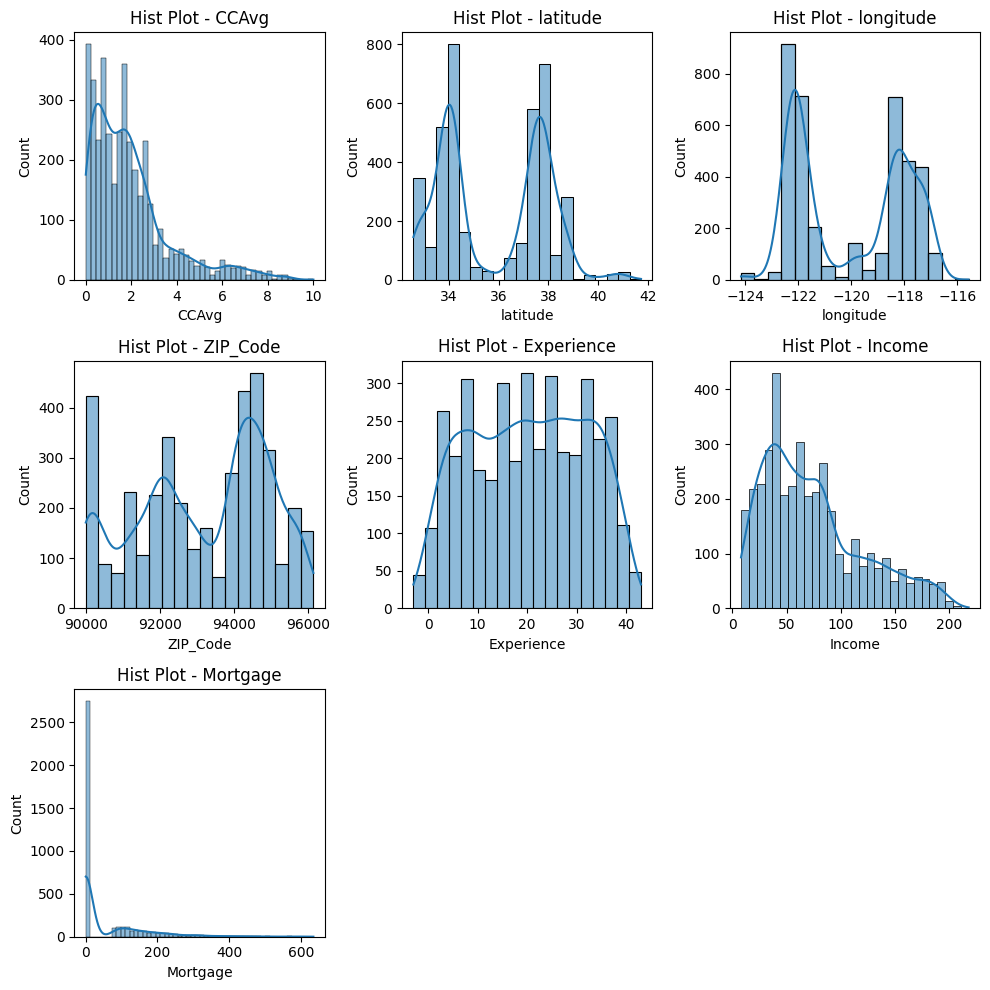

In [26]:
# Plot histograms
ncol_max = 3
nrow_max = math.ceil(len(numerical_feats)/ncol_max)
fig, axs = plt.subplots(nrows = nrow_max, ncols = ncol_max, figsize=(10, 10))


# Flatten axes for easy iteration
axs = axs.flatten()

# Histograms
for col in numerical_feats:  
        # Plotting the histograms
        sns.histplot(data = bank[numerical_feats], 
                     x= bank[col], 
                     kde = True,                                   
                     ax=axs[bank[numerical_feats].columns.get_loc(col)])
        
        # Formatting
        axs[bank[numerical_feats].columns.get_loc(col)].set_xlabel(col)
        axs[bank[numerical_feats].columns.get_loc(col)].set_title(f'Hist Plot - {col}')
        
# Hide unused subplots
for ax in axs[len(numerical_feats):]:
    ax.axis('off')
    
# Adjust layout
plt.tight_layout()
plt.show()

Let's plot the violin plots of the numerical features .


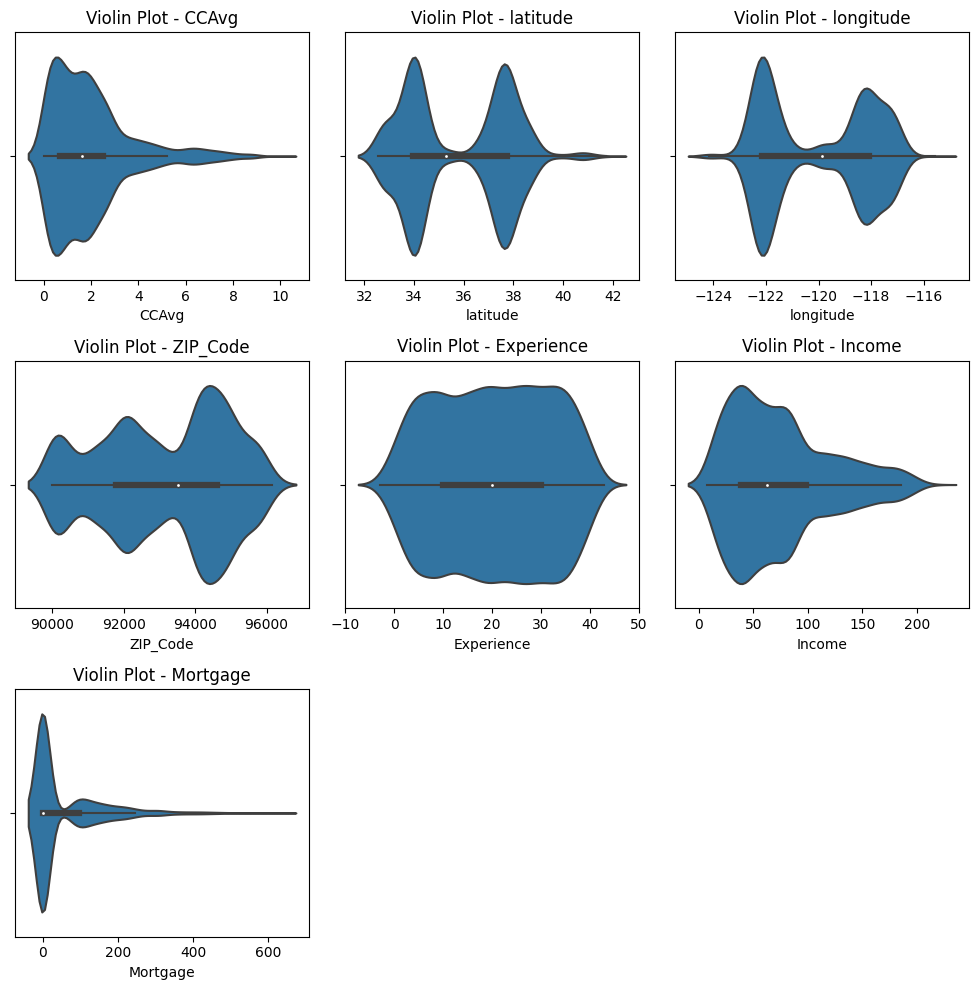

In [27]:
# Plot violin plots
ncol_max = 3
nrow_max = math.ceil(len(numerical_feats)/ncol_max)
fig, axs = plt.subplots(nrows = nrow_max, ncols = ncol_max, figsize=(10, 10))


# Flatten axes for easy iteration
axs = axs.flatten()

# boxplots
for col in numerical_feats:  
        # Plotting the violin plots
        sns.violinplot(data = bank[numerical_feats], 
                     x= bank[col],                                   
                     ax=axs[bank[numerical_feats].columns.get_loc(col)])
        
        # Formatting
        axs[bank[numerical_feats].columns.get_loc(col)].set_xlabel(col)
        axs[bank[numerical_feats].columns.get_loc(col)].set_title(f'Violin Plot - {col}')  

# Hide unused subplots
for ax in axs[len(numerical_feats):]:
    ax.axis('off')
    
# Adjust layout
plt.tight_layout()
plt.show()


Let's plot the boxplots of the numerical features.

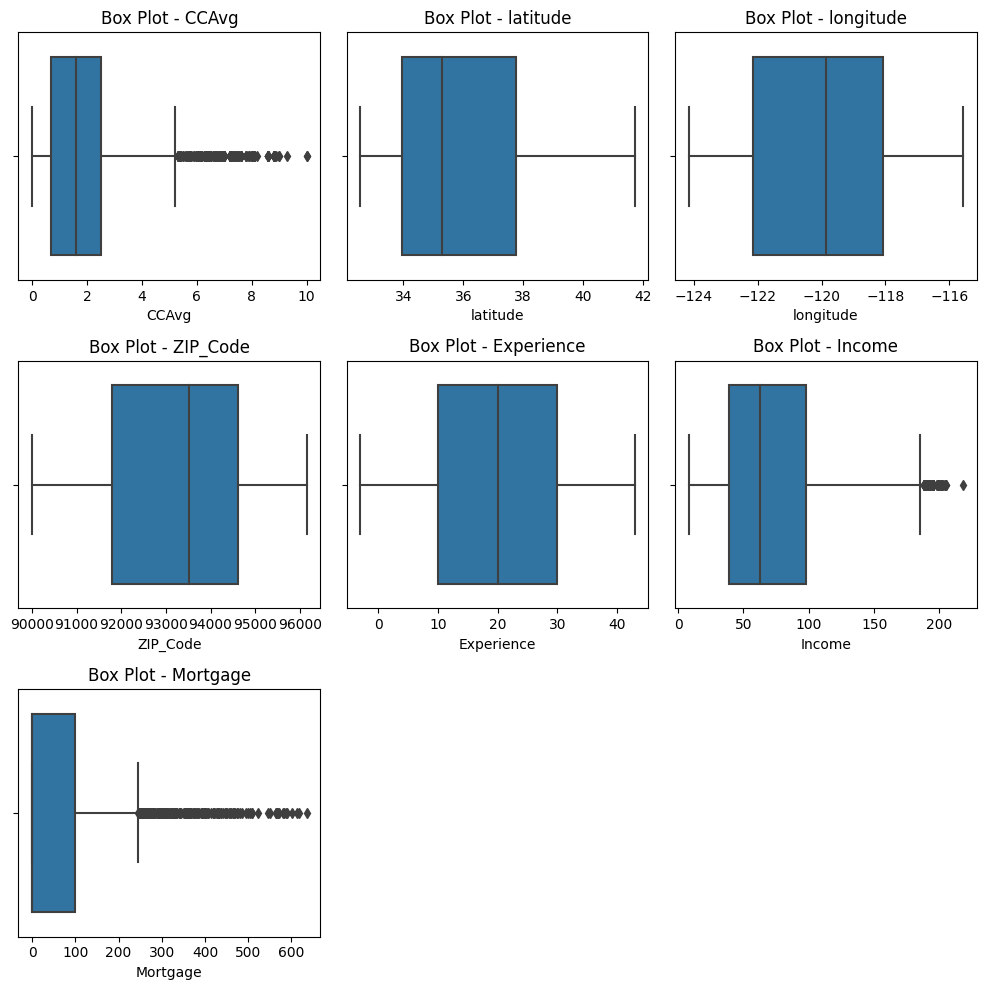

In [28]:
# Plot boxplots
ncol_max = 3
nrow_max = math.ceil(len(numerical_feats)/ncol_max)
fig, axs = plt.subplots(nrows = nrow_max, ncols = ncol_max, figsize=(10, 10))


# Flatten axes for easy iteration
axs = axs.flatten()

# boxplots
for col in numerical_feats:  
        # Plotting the boxplots
        sns.boxplot(data = bank[numerical_feats], 
                     x= bank[col],                                   
                     ax=axs[bank[numerical_feats].columns.get_loc(col)])
        
        # Formatting
        axs[bank[numerical_feats].columns.get_loc(col)].set_xlabel(col)
        axs[bank[numerical_feats].columns.get_loc(col)].set_title(f'Box Plot - {col}')  
        
# Hide unused subplots
for ax in axs[len(numerical_feats):]:
    ax.axis('off')
    
# Adjust layout
plt.tight_layout()
plt.show()


**Insights** :

- CCAvg : The median spending on credit card per month is **around 1500 USD**.
- Age : The median age is **around 45 years old**.
- Experience : The median number of years of professional experience is **around 20 years**.
- Income : The median income is around **70 000 USD**.


#### Categorical features



In [29]:
# Categorical features
categories_feats = categorical_feats + binary_feats
categories_feats

['Education',
 'Personal_Loan',
 'Family',
 'Securities_Account',
 'CD_Account',
 'Online',
 'CreditCard']

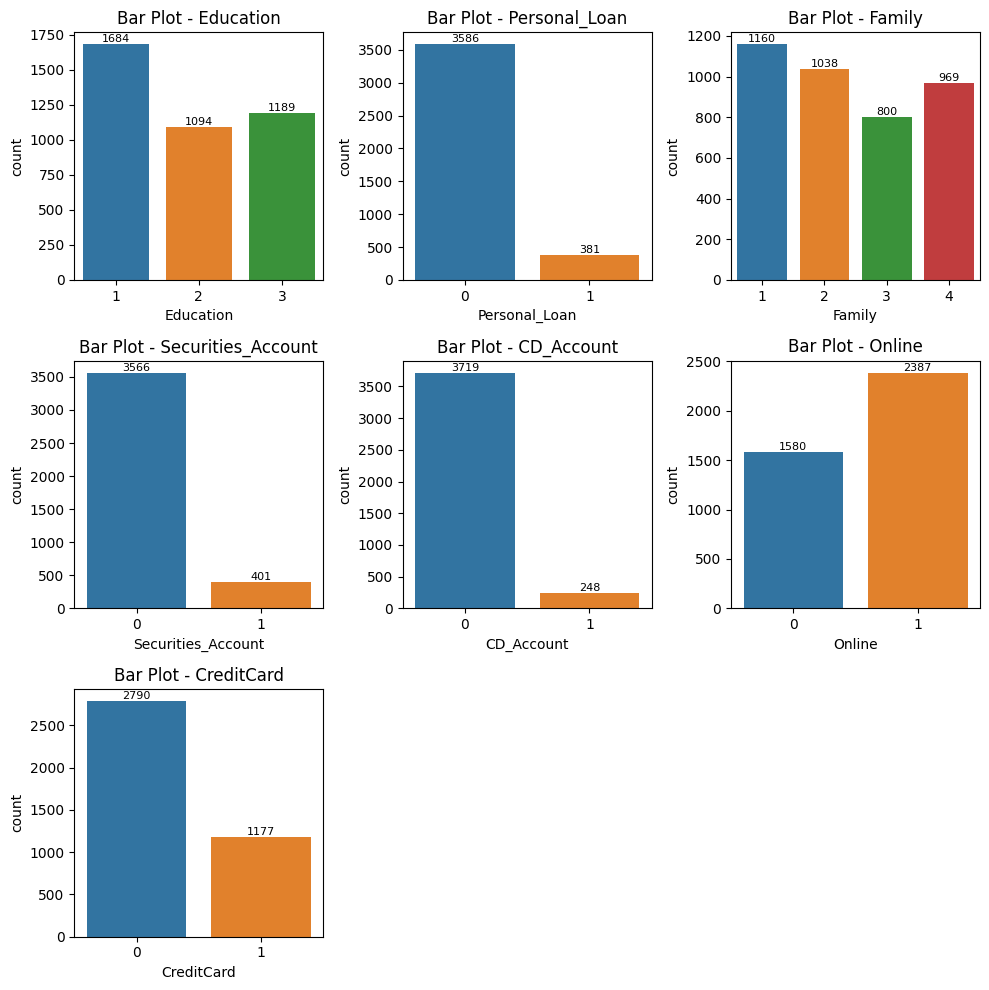

In [30]:
# Plot count plots
ncol_max = 3
nrow_max = math.ceil(len(categories_feats)/ncol_max)
fig, axs = plt.subplots(nrows = nrow_max, ncols = ncol_max, figsize=(10, 10))

# Flatten axes for easy iteration
axs = axs.flatten()

# countplots
for col in categories_feats:         
        # Plotting the count plots
        sns.countplot(data = bank[categories_feats], 
                     x= bank[col],                                   
                     ax=axs[bank[categories_feats].columns.get_loc(col)])
        
        # Formatting
        axs[bank[categories_feats].columns.get_loc(col)].set_xlabel(col)
        axs[bank[categories_feats].columns.get_loc(col)].set_title(f'Bar Plot - {col}')  
        axs[bank[categories_feats].columns.get_loc(col)].bar_label(            
            axs[bank[categories_feats].columns.get_loc(col)].containers[0],
            fontsize=8
            )       

# Hide unused subplots
for ax in axs[len(categories_feats):]:
    ax.axis('off')
           
# Adjust layout
plt.tight_layout()
plt.show()


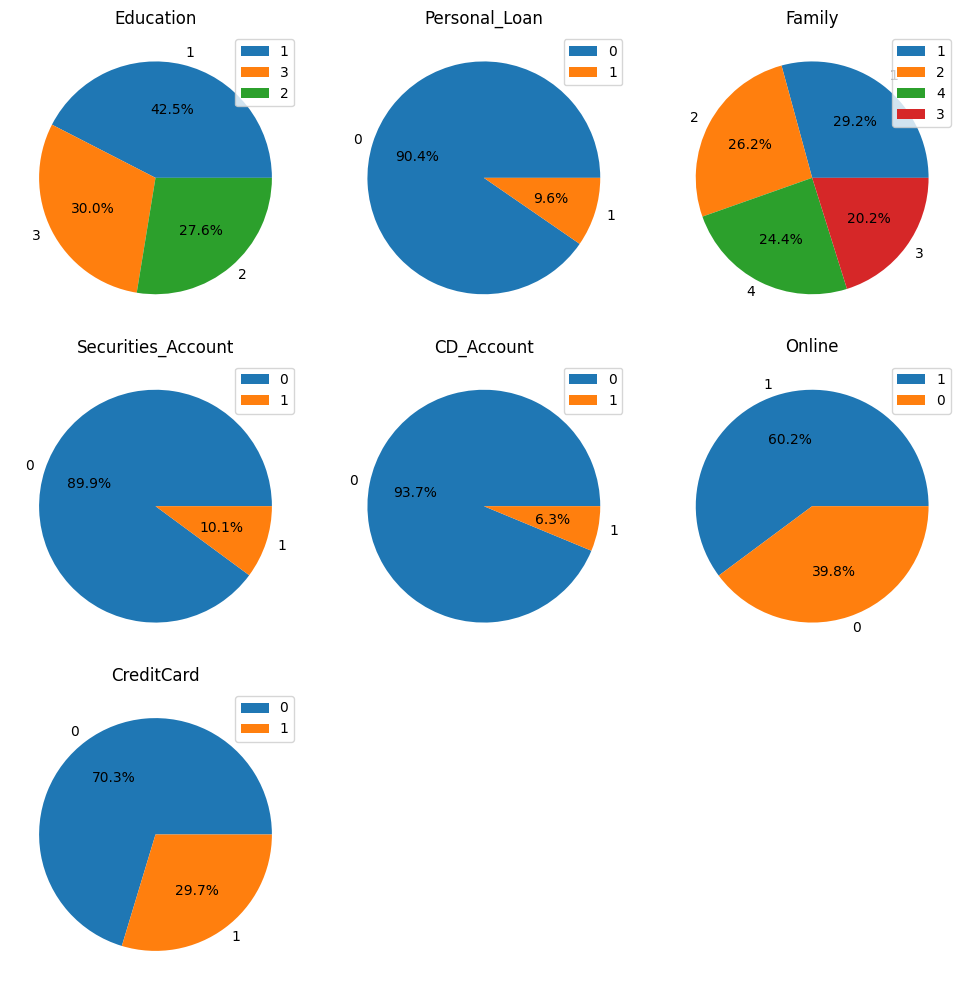

In [31]:
# Plot pie charts
ncol_max = 3
nrow_max = math.ceil(len(categories_feats)/ncol_max)
fig, axs = plt.subplots(nrows = nrow_max, ncols = ncol_max, figsize=(10, 10))

# Flatten axes for easy iteration
axs = axs.flatten()

# boxplots
for col in categories_feats:  
        # Example DataFrame
        data = pd.DataFrame({'Category': bank[col].value_counts().index.values, 
                             'Values': bank[col].value_counts().values})

        # Create a pie chart
        data.set_index('Category').plot.pie(y='Values',
                                            autopct='%1.1f%%', 
                                            ax = axs[bank[categories_feats].columns.get_loc(col)])
        
        # Formatting
        axs[bank[categories_feats].columns.get_loc(col)].set_title(f'{col}') 
        axs[bank[categories_feats].columns.get_loc(col)].set_ylabel('')              

# Hide unused subplots
for ax in axs[len(categories_feats):]:
    ax.axis('off')
    
# Adjust layout
plt.tight_layout()
plt.show()

### Bivariate analysis


#### Correlation


What is the correlation between the numericals features ?

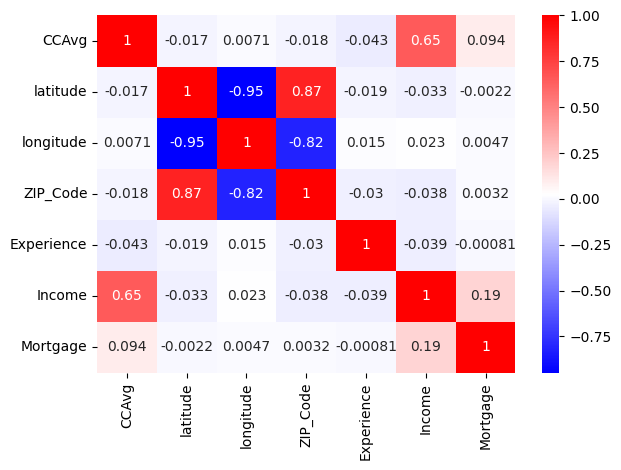

In [32]:
# Heatmap of pairwise correlations
correlation_matrix = bank[numerical_feats].corr()
column_names = correlation_matrix.columns
sns.heatmap(correlation_matrix, 
            xticklabels=column_names, 
            yticklabels=column_names,
            cmap= "bwr",
           annot=True);
plt.tight_layout()
plt.show()

In [33]:
#Create a dataframe listing pair correlations and absolute correlations
correlation_matrix = bank[numerical_feats].corr()

# Converting the correlation matrix into a DataFrame
corr_df = correlation_matrix.stack().reset_index()

# Renaming the columns
corr_df.columns = ['feature_1','feature_2', 'correlation']

# Remove "self correlations"
no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
corr_df = corr_df[no_self_correlation]

corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])

corr_df.sort_values(by="absolute_correlation", ascending=False, inplace = True)
corr_df.head(10)


feature_1  feature_2  correlation  absolute_correlation
15  longitude   latitude    -0.949208              0.949208
9    latitude  longitude    -0.949208              0.949208
10   latitude   ZIP_Code     0.867999              0.867999
22   ZIP_Code   latitude     0.867999              0.867999
23   ZIP_Code  longitude    -0.818264              0.818264
17  longitude   ZIP_Code    -0.818264              0.818264
35     Income      CCAvg     0.650881              0.650881
5       CCAvg     Income     0.650881              0.650881
47   Mortgage     Income     0.191926              0.191926
41     Income   Mortgage     0.191926              0.191926

We see that **Experience** and **Age** have **more than 99% correlation**.<br>
We may drop one of these later on.


We see that **latitude** and **longitude** have **more than 94% correlation**.<br>
We may drop one of these later on.


#### Scatter matrix


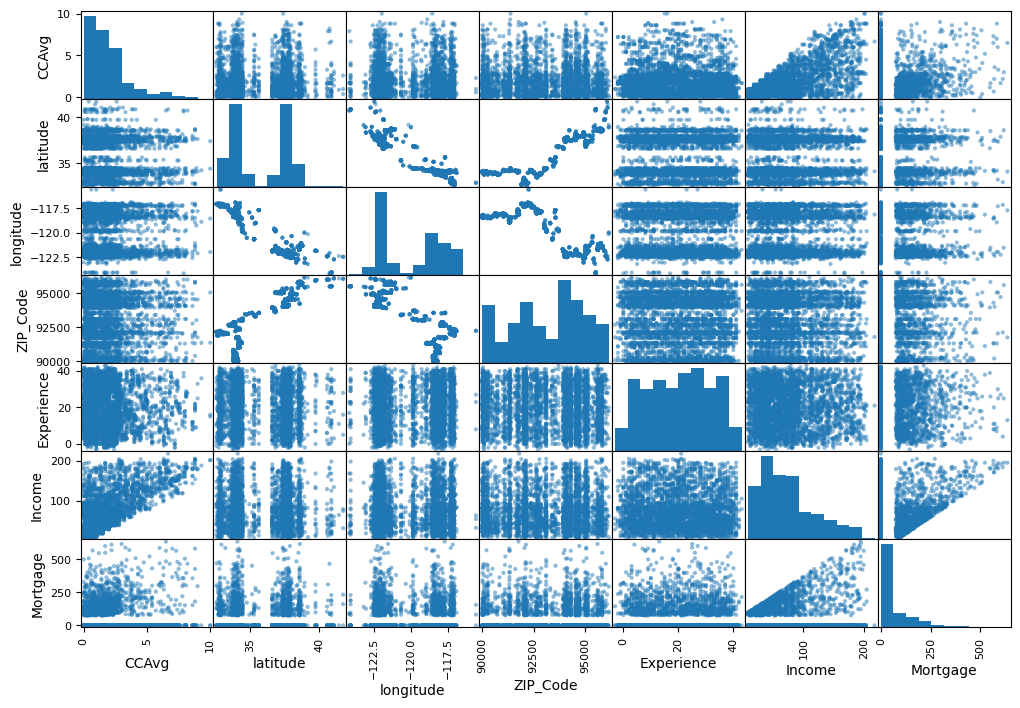

In [34]:
# Display scatter matrix for numerical
scatter_matrix(bank[numerical_feats], figsize= (12,8))
plt.show()

### Visualizing Geographical data


We locate each customer based on their coordinates.


In [35]:
# Visualize geographic data using scatter_mapbox
fig = px.scatter_mapbox(bank, 
                         lat='latitude', 
                         lon='longitude', 
                         center=dict(lat=37, lon=-120),
                         size_max=20,
                         zoom=4,
                         # size='Personal_Loan',
                         color='Personal_Loan',
                         height=600,
                         title='<b> Visualize geographic data using scatter_mapbox</b>',
                         color_continuous_scale=px.colors.sequential.Viridis)

fig.update_layout(mapbox_style='open-street-map', height=600)
fig.show()


# Prepare the data for Machine Learning Algorithms


We separate the features from the target.

We drop **Age** and **longitude** to avoid redundancy with **Experience** and **latitude**.


In [36]:
# Separate featues from target
X = strat_train_set.drop(["Personal_Loan","Age","longitude"], axis=1)
y = strat_train_set["Personal_Loan"].copy()

In [37]:
# Display the shapes of features and target
print(f"The shape of X : {X.shape}")
print(f"The shape of y : {y.shape}")

The shape of X : (3967, 12)
The shape of y : (3967,)


In [38]:
# Numerical features
numerical_features = X.columns

## Checking for outliers in numerical features


Let's check the outliers of the numerical columns.


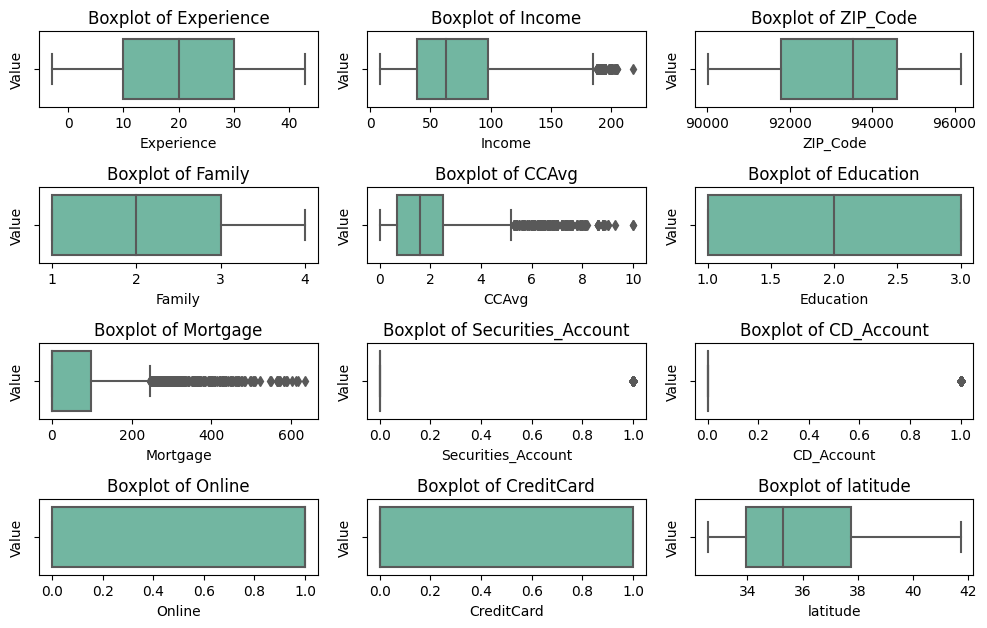

In [39]:
# Plot boxplots of each numerical column
plt.figure(figsize=(10, 20))

# for column in housing_num_tr.columns: 
for i, column in enumerate(numerical_features, 1):
    plt.subplot(13, 3, i)
    sns.boxplot(x=X[column], palette='Set2')
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

It would be useful to extract the features containing outliers **automatically**. It will be used for pipeline implementation.


Let's extract the features with outliers **numerically** !


In [40]:
# Identify the columns with outliers
numerical_columns_w_outliers = []
numerical_columns_no_outliers = []

for col in X[numerical_features].columns: 
    # Calculate IQR
    iqr_value = iqr(X[col])

    #Calculate 1st quartile
    q1 = np.percentile(X[col],25)

    #Calculate 3rd quartile
    q3 = np.percentile(X[col],75)

    #Calculate lower limit below which data point is considered an outlier
    outlier_lim_low = q1 - 1.5 * iqr_value

    #Calculate higher limit above which data point is considered an outlier
    outlier_lim_high = q3 + 1.5 * iqr_value
    
    #Calculate number of 'low' outliers
    outlier_condition_low = X[col] < outlier_lim_low
    number_outliers_low = len(X[outlier_condition_low][col])
    
    #Calculate number of 'high' outliers
    outlier_condition_high = X[col] > outlier_lim_high
    number_outliers_high = len(X[outlier_condition_high][col])
    
    #Calculate total number of outliers
    number_outliers_total = number_outliers_low + number_outliers_high
      
    #If any outliers in column, column is added to a list of columns with outliers
    if number_outliers_total > 0:
        numerical_columns_w_outliers.append(col)
    elif number_outliers_total == 0:
        numerical_columns_no_outliers.append(col)     
        

Let's check if we could extract the outliers **numerically** !



In [41]:
print(f"The features having outliers are : {numerical_columns_w_outliers}")
print(f"The features WITHOUT outliers are : {numerical_columns_no_outliers}")

The features having outliers are : ['Income', 'CCAvg', 'Mortgage', 'Securities_Account', 'CD_Account']
The features WITHOUT outliers are : ['Experience', 'ZIP_Code', 'Family', 'Education', 'Online', 'CreditCard', 'latitude']


## Feature scaling and transformation


**WHY SCALING ??**

❗️ Features with large magnitudes can incorrectly outweigh features of small magnitudes <br>
⚡️ Scaling to smaller magnitudes improves computational efficiency <br>
🕵🏻‍♂️ Increases interpretability about the impact of each feature in a Machine Learning model <br>

### Columns with outliers


<span style="font-family:Comic Sans MS; color:red">We consider using Robust scaling for columns WITH outliers !  </span>

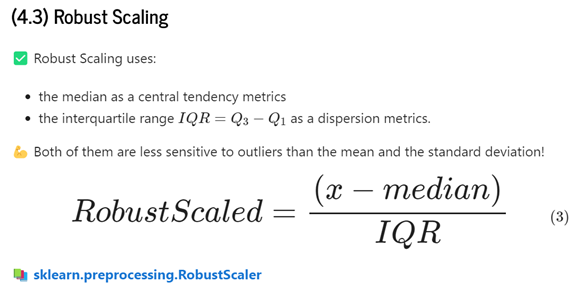


In [42]:
# Reminder of features with outliers
display(numerical_columns_w_outliers)

['Income', 'CCAvg', 'Mortgage', 'Securities_Account', 'CD_Account']

Let's have a look of the statistics of numerical columns with outliers (**BEFORE SCALING**).

In [43]:
# Describe columns with outliers
X[numerical_columns_w_outliers].describe()

Income        CCAvg     Mortgage  Securities_Account   CD_Account
count  3967.000000  3967.000000  3967.000000         3967.000000  3967.000000
mean     73.753214     1.937854    55.387194            0.101084     0.062516
std      46.157581     1.737837   100.255256            0.301478     0.242120
min       8.000000     0.000000     0.000000            0.000000     0.000000
25%      39.000000     0.700000     0.000000            0.000000     0.000000
50%      63.000000     1.600000     0.000000            0.000000     0.000000
75%      98.000000     2.500000    98.000000            0.000000     0.000000
max     218.000000    10.000000   635.000000            1.000000     1.000000

In [44]:
# Instantiate Robustscaler
robust_scaler = RobustScaler()

# Fit and transform
X[numerical_columns_w_outliers] = robust_scaler.fit_transform(X[numerical_columns_w_outliers])
X[numerical_columns_w_outliers].head(3)

Income     CCAvg  Mortgage  Securities_Account  CD_Account
1996 -0.423729 -0.111111       0.0                 0.0         0.0
2798 -0.593220 -0.722222       0.0                 0.0         0.0
4944 -0.508475  0.055556       0.0                 0.0         0.0

Now, let's check the statistics of the numerical columns with outliers (**AFTER SCALING**).

In [45]:
# Describe columns with outliers
X[numerical_columns_w_outliers].describe()

Income        CCAvg     Mortgage  Securities_Account   CD_Account
count  3967.000000  3967.000000  3967.000000         3967.000000  3967.000000
mean      0.182258     0.187697     0.565175            0.101084     0.062516
std       0.782332     0.965465     1.023013            0.301478     0.242120
min      -0.932203    -0.888889     0.000000            0.000000     0.000000
25%      -0.406780    -0.500000     0.000000            0.000000     0.000000
50%       0.000000     0.000000     0.000000            0.000000     0.000000
75%       0.593220     0.500000     1.000000            0.000000     0.000000
max       2.627119     4.666667     6.479592            1.000000     1.000000

### Columns without outliers


<span style="font-family:Comic Sans MS; color:red">We consider using MinMax scaling for columns WITHOUT outliers !  </span>

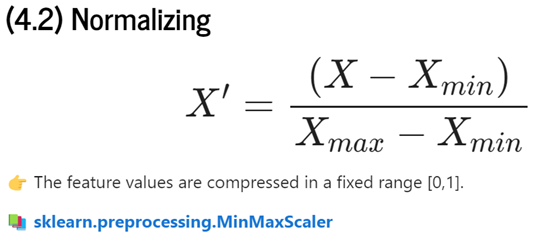
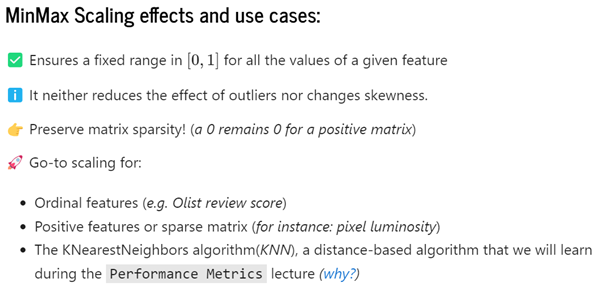


Let's have a look of the statistics of numerical columns without outliers (**BEFORE SCALING**).

In [46]:
# Describe columns with NO outliers
X[numerical_columns_no_outliers].describe()

Experience      ZIP_Code       Family    Education       Online  \
count  3967.000000   3967.000000  3967.000000  3967.000000  3967.000000   
mean     20.245274  93165.771112     2.397782     1.875221     0.601714   
std      11.518894   1764.457576     1.145966     0.841923     0.489607   
min      -3.000000  90005.000000     1.000000     1.000000     0.000000   
25%      10.000000  91791.000000     1.000000     1.000000     0.000000   
50%      20.000000  93524.000000     2.000000     2.000000     1.000000   
75%      30.000000  94608.000000     3.000000     3.000000     1.000000   
max      43.000000  96150.000000     4.000000     3.000000     1.000000   

        CreditCard     latitude  
count  3967.000000  3967.000000  
mean      0.296698    35.791194  
std       0.456860     2.104921  
min       0.000000    32.562600  
25%       0.000000    33.953300  
50%       0.000000    35.303900  
75%       1.000000    37.750900  
max       1.000000    41.724300

In [47]:
#Instanciate, fit, transform with minmax scaler
minmax_scaler = MinMaxScaler()
X[numerical_columns_no_outliers] = minmax_scaler.fit_transform(X[numerical_columns_no_outliers])

Now, let's check the statistics of the numerical columns without outliers (**AFTER SCALING**).

In [48]:
# Describe columns with NO outliers
X[numerical_columns_no_outliers].describe()

Experience     ZIP_Code       Family    Education       Online  \
count  3967.000000  3967.000000  3967.000000  3967.000000  3967.000000   
mean      0.505332     0.514365     0.465927     0.437610     0.601714   
std       0.250411     0.287137     0.381989     0.420961     0.489607   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.282609     0.290643     0.000000     0.000000     0.000000   
50%       0.500000     0.572661     0.333333     0.500000     1.000000   
75%       0.717391     0.749064     0.666667     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

        CreditCard     latitude  
count  3967.000000  3967.000000  
mean      0.296698     0.352401  
std       0.456860     0.229752  
min       0.000000     0.000000  
25%       0.000000     0.151795  
50%       0.000000     0.299213  
75%       1.000000     0.566303  
max       1.000000     1.000000

## Create pipelines


In [50]:
# Create pipelines
preprocessing = make_column_transformer(
                                        (RobustScaler(), numerical_columns_w_outliers),
                                        (MinMaxScaler(), numerical_columns_no_outliers),
                                        remainder='passthrough'
                                        )

preprocessing.fit(X)

ColumnTransformer(remainder='passthrough',
                  transformers=[('robustscaler', RobustScaler(),
                                 ['Income', 'CCAvg', 'Mortgage',
                                  'Securities_Account', 'CD_Account']),
                                ('minmaxscaler', MinMaxScaler(),
                                 ['Experience', 'ZIP_Code', 'Family',
                                  'Education', 'Online', 'CreditCard',
                                  'latitude'])])

# Oversampling the minority class for training using SMOTE


In [51]:
# Separate featues from target
X = strat_train_set.drop(["Personal_Loan","Age","longitude"], axis=1)
y = strat_train_set["Personal_Loan"].copy()

In [52]:
# Check of stratified train set
y.value_counts()/len(strat_train_set)*100

0    90.395765
1     9.604235
Name: Personal_Loan, dtype: float64

In [53]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(random_state=42)
# X_smote, y_smote = smote.fit_resample(X, y)

In [54]:
# # Check of stratified train set
# y_smote.value_counts()/len(y_smote)*100

0    50.0
1    50.0
Name: Personal_Loan, dtype: float64

# Train and evaluate on the training set with several models

Now, let's use several classification models.


In [55]:
%%time

# Selection of models to try out
classification_models = [LogisticRegression(random_state=42), 
                         LinearSVC(random_state=42), 
                         KNeighborsClassifier()]

mean_recall_scores = {}
mean_precision_scores = {}
mean_f1_scores = {}

# Train and evaluate the models
for model in classification_models:
    piped_model = make_pipeline(preprocessing, model)
    piped_model.fit(X, y)
    scores = cross_validate(piped_model, X, y, cv=20, scoring=['recall', 'precision', 'f1'])
    
    #Calculate mean scores     
    mean_recall_score = scores['test_recall'].mean()
    mean_precision_score = scores['test_precision'].mean()
    mean_f1_score = scores['test_f1'].mean()
    
    # Store mean scores in dicts     
    mean_recall_scores[str(model)[:str(model).find('(')]] = mean_recall_score
    mean_precision_scores[str(model)[:str(model).find('(')]] = mean_precision_score
    mean_f1_scores[str(model)[:str(model).find('(')]] = mean_f1_score
 
    
# Formatting the results into a dataframe (RECALL)
mean_recall_scores_df = pd.DataFrame(mean_recall_scores, index=[0])
mean_recall_scores_df = mean_recall_scores_df.T\
                                .reset_index()\
                                .rename(columns={0:'recall', 'index' : 'Model'})\
                                .sort_values('recall', ascending=False)

# Formatting the results into a dataframe (PRECISION)
mean_precision_scores_df = pd.DataFrame(mean_precision_scores, index=[0])
mean_precision_scores_df = mean_precision_scores_df.T\
                                .reset_index()\
                                .rename(columns={0:'precision', 'index' : 'Model'})\
                                .sort_values('precision', ascending=False)

# Formatting the results into a dataframe (F1)
mean_f1_scores_df = pd.DataFrame(mean_f1_scores, index=[0])
mean_f1_scores_df = mean_f1_scores_df.T\
                                .reset_index()\
                                .rename(columns={0:'F1', 'index' : 'Model'})\
                                .sort_values('F1', ascending=False)

# Merge
merged = pd.merge(mean_recall_scores_df,mean_precision_scores_df,
                        how='left',
                        left_on='Model',
                        right_on='Model')


merged = pd.merge(merged,mean_f1_scores_df,
                        how='left',
                        left_on='Model',
                        right_on='Model').sort_values('recall', ascending=False)
                
display(merged)

Model    recall  precision        F1
0  KNeighborsClassifier  0.976296   0.920069  0.947252
1             LinearSVC  0.904336   0.886921  0.895427
2    LogisticRegression  0.903498   0.887811  0.895460

CPU times: user 6.9 s, sys: 8.47 s, total: 15.4 s
Wall time: 4.24 s


**KNeighborsClassifier** has the **best recall**, **best precision**  and **best F1 score**.



# Fine tune the model


Let's fine tuned our chosen model (**KNeighbors Classifier**).


## Grid Search

In [56]:
# Reminder of the pipeline structure
Kneighbors_pipe= make_pipeline(preprocessing, KNeighborsClassifier())
Kneighbors_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('robustscaler',
                                                  RobustScaler(),
                                                  ['Income', 'CCAvg',
                                                   'Mortgage',
                                                   'Securities_Account',
                                                   'CD_Account']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['Experience', 'ZIP_Code',
                                                   'Family', 'Education',
                                                   'Online', 'CreditCard',
                                                   'latitude'])])),
                ('kneighborsclassifier', KNeighborsClassifier())])

What are the available hyper parameters of the classifier ?


In [57]:
# Get the pipeline parmeters
Kneighbors_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'kneighborsclassifier', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__robustscaler', 'columntransformer__minmaxscaler', 'columntransformer__robustscaler__copy', 'columntransformer__robustscaler__quantile_range', 'columntransformer__robustscaler__unit_variance', 'columntransformer__robustscaler__with_centering', 'columntransformer__robustscaler__with_scaling', 'columntransformer__minmaxscaler__clip', 'columntransformer__minmaxscaler__copy', 'columntransformer__minmaxscaler__feature_range', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'knei

In [58]:
%%time
# Create grid
param_grid = [
                {'kneighborsclassifier__n_neighbors' : [2, 5, 10]}
            ]

# Perform Grid Search
grid_search = GridSearchCV(Kneighbors_pipe, param_grid, cv=20,scoring=['recall', 'precision', 'f1'], refit='recall')


# Fit data to Grid Search
grid_search.fit(X, y)


CPU times: user 1.83 s, sys: 1.87 ms, total: 1.84 s
Wall time: 1.84 s


GridSearchCV(cv=20,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('robustscaler',
                                                                         RobustScaler(),
                                                                         ['Income',
                                                                          'CCAvg',
                                                                          'Mortgage',
                                                                          'Securities_Account',
                                                                          'CD_Account']),
                                                                        ('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         ['Experience',
                                                                          'ZIP_Code',
                                                                          'Family',
                                                                          'Education',
                                                                          'Online',
                                                                          'CreditCard',
                                                                          'latitude'])])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid=[{'kneighborsclassifier__n_neighbors': [2, 5, 10]}],
             refit='recall', scoring=['recall', 'precision', 'f1'])

The best hyperparameter combination found:

In [59]:
# Get the best params found
grid_search.best_params_

{'kneighborsclassifier__n_neighbors': 5}

In [60]:
# Get the best estimator found
grid_search.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('robustscaler',
                                                  RobustScaler(),
                                                  ['Income', 'CCAvg',
                                                   'Mortgage',
                                                   'Securities_Account',
                                                   'CD_Account']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['Experience', 'ZIP_Code',
                                                   'Family', 'Education',
                                                   'Online', 'CreditCard',
                                                   'latitude'])])),
                ('kneighborsclassifier', KNeighborsClassifier())])

👎 Limitations of Grid Search:<br>
•	Computationally costly <br>
•	The optimal hyperparameter value can be missed <br>
•	Can overfit hyperparameters to the training set if too many combinations are tried out for too small a dataset

So let's try a **random grid search** !

## Random search

Randomly explore hyperparameter values from: <br>
•	A hyperparameter space to randomly sample from <br>
•	The specified number of samples to be tested

In [61]:
#### %%time
# Create grid
# param_distribs = [
#                 {'kneighborsclassifier__n_neighbors' : [np.random.randint(low = 1, high = 200)]}
#             ]

param_distribs = {
    'kneighborsclassifier__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'kneighborsclassifier__leaf_size' : [np.random.randint(low = 1, high = 10)],
     'kneighborsclassifier__n_neighbors' : [np.random.randint(low = 1, high = 9)],
     'kneighborsclassifier__weights' : ['uniform', 'distance']}

# Perform Grid Search
rnd_search = RandomizedSearchCV(Kneighbors_pipe, 
                                param_distributions=param_distribs,
                                cv=20,
                                scoring='f1')
# Fit data to Grid Search
rnd_search.fit(X, y)

RandomizedSearchCV(cv=20,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('robustscaler',
                                                                               RobustScaler(),
                                                                               ['Income',
                                                                                'CCAvg',
                                                                                'Mortgage',
                                                                                'Securities_Account',
                                                                                'CD_Account']),
                                                                              ('minmaxscaler',
                                                                               MinMaxScaler(),
                                                                               ['Experience',
                                                                                'ZIP_Code',
                                                                                'Family',
                                                                                'Education',
                                                                                'Online',
                                                                                'CreditCard',
                                                                                'latitude'])])),
                                             ('kneighborsclassifier',
                                              KNeighborsClassifier())]),
                   param_distributions={'kneighborsclassifier__algorithm': ['auto',
                                                                            'ball_tree',
                                                                            'kd_tree',
                                                                            'brute'],
                                        'kneighborsclassifier__leaf_size': [4],
                                        'kneighborsclassifier__n_neighbors': [6],
                                        'kneighborsclassifier__weights': ['uniform',
                                                                          'distance']},
                   scoring='f1')

The best hyperparameter combination found:

In [62]:
# Get the best params found
rnd_search.best_params_

{'kneighborsclassifier__weights': 'distance',
 'kneighborsclassifier__n_neighbors': 6,
 'kneighborsclassifier__leaf_size': 4,
 'kneighborsclassifier__algorithm': 'auto'}

In [63]:
# Get the best estimator found
rnd_search.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('robustscaler',
                                                  RobustScaler(),
                                                  ['Income', 'CCAvg',
                                                   'Mortgage',
                                                   'Securities_Account',
                                                   'CD_Account']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['Experience', 'ZIP_Code',
                                                   'Family', 'Education',
                                                   'Online', 'CreditCard',
                                                   'latitude'])])),
                ('kneighborsclassifier',
                 KNeighborsClassifier(leaf_size=4, n_neighbors=6,
                                      weights='distance'))])

In [64]:
# Final model 
final_model = rnd_search.best_estimator_  # includes preprocessing

# Evaluate the system on the Test set


In [65]:
# Separate featues from target
X_test = strat_test_set.drop(["Personal_Loan","Age","longitude"], axis=1)
y_test = strat_test_set["Personal_Loan"].copy()

In [66]:
# Make the predictions
final_predictions = final_model.predict(X_test)

In [67]:
# Calculation of metric
final_recall = recall_score(y_test, final_predictions)
final_precision = precision_score(y_test, final_predictions)
final_f1 = f1_score(y_test, final_predictions)

print(f"Final recall : {final_recall}")
print(f"Final precision : {final_precision}")
print(f"Final f1 : {final_f1}")


Final recall : 0.9052631578947369
Final precision : 0.5477707006369427
Final f1 : 0.6825396825396826


In [68]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, final_predictions)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[826  71]
 [  9  86]]


In [69]:
print(classification_report(y_test,final_predictions))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95       897
           1       0.55      0.91      0.68        95

    accuracy                           0.92       992
   macro avg       0.77      0.91      0.82       992
weighted avg       0.95      0.92      0.93       992



# Save the model


In [70]:
# Saving the best model
joblib.dump(final_model, "../data/processed_data/my_bank_model.pkl")

['../data/processed_data/my_bank_model.pkl']

# Load the model 


In [71]:
# Reloading the saved model
final_model_reloaded = joblib.load("../data/processed_data/my_bank_model.pkl")

In [72]:
# Make new predictions
new_data = X_test.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)
predictions

array([0, 0, 0, 1, 0])

# Conclusion


We got a model that has a **recall** higher than **90%** on class 1.

